## IN3050/IN4050 Mandatory Assignment 2: Supervised Learning

Name: Espen Lønes    
Username: espenlon    
Solved in jupyter notebook. PDF is made from the notebook

### Rules

Before you begin the exercise, review the rules at this website: https://www.uio.no/english/studies/examinations/compulsory-activities/mn-ifi-mandatory.html , in particular the paragraph on cooperation. This is an individual assignment. You are not allowed to deliver together or copy/share source-code/answers with others. Read also the "Routines for handling suspicion of cheating and attempted cheating at the University of Oslo" https://www.uio.no/english/about/regulations/studies/studies-examinations/routines-cheating.html By submitting this assignment, you confirm that you are familiar with the rules and the consequences of breaking them.

### Delivery

**Deadline**: Friday, March 19, 2021, 23:59

Your submission should be delivered in Devilry. You may redeliver in Devilry before the deadline, but include all files in the last delivery, as only the last delivery will be read. You are recommended to upload preliminary versions hours (or days) before the final deadline.

### What to deliver?

You are recommended to solve the exercise in a Jupyter notebook, but you might solve it in a Python program if you prefer.

If you choose Jupyter, you should deliver the notebook. You should answer all questions and explain what you are doing in Markdown. Still, the code should be properly commented. The notebook should contain results of your runs. In addition, you should make a pdf of your solution which shows the results of the runs.

If you prefer not to use notebooks, you should deliver the code, your run results, and a pdf-report where you answer all the questions and explain your work.

Your report/notebook should contain your name and username.

Deliver one single zipped folder (.zip, .tgz or .tar.gz) which contains your complete solution.

Important: if you weren’t able to finish the assignment, use the PDF report/Markdown to elaborate on what you’ve tried and what problems you encountered. Students who have made an effort and attempted all parts of the assignment will get a second chance even if they fail initially. This exercise will be graded PASS/FAIL.


### Goals of the exercise
This exercise has three parts. The goal of the first part is to get more experience with supervised classification. We will use simple synthetic datasets and focus on the learning algorithms. 

The goal of the second part is to consider the implementaion of the  Multi-layer feed forward neural network, often called Multi-layer perceptron (MLP).

The third part, which is the smallest one, is dedicated to evaluation.

### Tools
The aim of the exercises is to give you a look inside the learning algorithms. You may freely use code from the weekly exercises and the published solutions. You should not use ML libraries like scikit-learn or tensorflow.

You may use tools like NumPy and Pandas, which are not specific ML-tools.

### Beware
There might occur typos or ambiguities. If anything is unclear, do not hesitate to ask. Also, if you think some assumptions are missing, make your own and explain them!

### Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
import random
from collections import Counter
import pandas as pd

# Part 1: Comparing classifiers
## Datasets
We start by making a synthetic dataset of 1600 datapoints and three classes, with 800 individuals in one class and 400 in each of the two other classes. (See https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs regarding how the data are generated.)

When we are doing experiments in supervised learning, and the data are not already split into training and test sets, we should start by splitting the data. Sometimes there are natural ways to split the data, say training on data from one year and testing on data from a later year, but if that is not the case, we should shuffle the data randomly before splitting. (OK, that is not necessary with this particular synthetic data set, since it is already shuffled by default by scikit, but that will not be the case with real-world data.) We should split the data so that we keep the alignment between X and t, which may be achieved by shuffling the indices. We split into 50% for training, 25% for validation, and 25% for final testing. The set for final testing *must not be used* till the end of the assignment in part 3.

We fix the seed both for data set generation and for shuffling, so that we work on the same datasets when we rerun the experiments.

In [2]:
from sklearn.datasets import make_blobs
X, t = make_blobs(n_samples=[400,800,400], centers=[[0,0],[1,2],[2,3]], 
                  n_features=2, random_state=2019)

In [3]:
indices = np.arange(X.shape[0])
random.seed(2020)
random.shuffle(indices)
indices[:10]

array([1301,  293,  968,  624,  658,  574,  433,  368,  512,  353])

In [4]:
X_train = X[indices[:800],:]
X_val = X[indices[800:1200],:]
X_test = X[indices[1200:],:]
t_train = t[indices[:800]]
t_val = t[indices[800:1200]]
t_test = t[indices[1200:]]

Next, we will  make a second dataset by merging the two smaller classes in (X,t) and call the new set (X, t2). This will be a binary set.

In [5]:
t2_train = t_train == 1
t2_train = t2_train.astype('int')
t2_val = (t_val == 1).astype('int')
t2_test = (t_test == 1).astype('int')

Plot the two training sets.

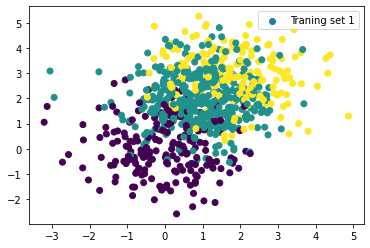

In [6]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=t_train, label="Traning set 1")
plt.legend()

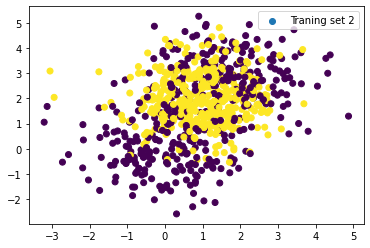

In [7]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=t2_train, label="Traning set 2")
plt.legend()

## Binary classifiers

### Linear regression
We see that that set (X, t2) is far from linearly separable, and we will explore how various classifiers are able to handle this. We start with linear regression. You may use the implementation from exercise set week07 or make your own. You should make one improvement. The implementation week07 runs for a set number of epochs. You provide the number of epochs with a parameter to the fit-method. However, you do not know what a reasonable number of epochs is. Add one more argument to the fit-method *diff* (with defualt value e.g. 0.001). The training should stop when the update is less than *diff*. The *diff* will save training time, but it may also be wise to not set it too small -- and not run training for too long -- to avoid overfitting.

Train the classifier on (X_train, t2_train) and test for accuracy on (X_val, t2_val) for various values of *diff*. Choose what you think is optimal *diff*. Report accuracy and save it for later.

In [96]:
#Used the linear regression implemtation from week07
def add_bias(X):
    # Put bias in position 0
    sh = X.shape
    if len(sh) == 1:
        #X is a vector
        return np.concatenate([np.array([1]), X])
    else:
        # X is a matrix
        m = sh[0]
        bias = np.ones((m,1)) # Makes a m*1 matrix of 1-s
        return np.concatenate([bias, X], axis  = 1)

class NumpyClassifier():
    """Common methods to all numpy classifiers --- if any"""
    
    def accuracy(self,X_test, y_test, **kwargs):
        pred = self.predict(X_test, **kwargs)
        if len(pred.shape) > 1:
            pred = pred[:,0]
        return sum(pred==y_test)/len(pred)
    
class NumpyLinRegClass(NumpyClassifier):

    def fit(self, X_train, t_train, eta = 0.1, diff=0.001):
        """X_train is a Nxm matrix, N data points, m features
        t_train are the targets values for training data"""
        
        (k, m) = X_train.shape
        X_train = add_bias(X_train)
        
        self.weights = weights = np.zeros(m+1)
        
        trigger = True
        while trigger:
            old_weights = weights.copy()
            weights -= eta / k *  X_train.T @ (X_train @ weights - t_train)
            
            
            counter = 0
            # check if all wheghts changed less than diff
            for i in range(len(weights)):
                if (abs(old_weights[i] - weights[i]) < diff):                  
                    counter += 1
            if counter == len(weights):
                trigger = False
        
    def predict(self, x, threshold=0.5):
        z = add_bias(x)
        score = z @ self.weights
        return score>threshold
    
lin_cl = NumpyLinRegClass()
lin_cl.fit(X_train, t2_train, diff=0.0001)
accuracy_lin_cl = lin_cl.accuracy(X_val, t2_val)
print(f"accuracy: {accuracy_lin_cl}")

accuracy: 0.6025


Chose to use diff of 0.0001 this gives an accuracy of 60%. Smaler diffs gave little improvement. So i chose 0.0001 as not to overfitt.

### Logistic regression
Do the same for logistic regression, i.e., add the *diff*, tune it, report accuracy, and store it for later.

In [9]:
#Used the logic regression implemtation from week07
def logistic(x):
    return 1/(1+np.exp(-x))

class NumpyLogReg(NumpyClassifier):

    def fit(self, X_train, t_train, eta = 0.1, diff=0.001):
        """X_train is a Nxm matrix, N data points, m features
        t_train are the targets values for training data"""
        
        (k, m) = X_train.shape
        X_train = add_bias(X_train)
        
        self.weights = weights = np.zeros(m+1)
        
        trigger = True
        while trigger:
            old_weights = weights.copy()
            weights -= eta / k *  X_train.T @ (self.forward(X_train) - t_train)
            
            counter = 0
            # checl if all wheghts changed less than diff
            for i in range(len(weights)):
                if (abs(old_weights[i] - weights[i]) < diff):                  
                    counter += 1
            if counter == len(weights):
                trigger = False
    
    def forward(self, X):
        return logistic(X @ self.weights)
    
    def score(self, x):
        z = add_bias(x)
        score = self.forward(z)
        return score
    
    def predict(self, x, threshold=0.5):
        z = add_bias(x)
        score = self.forward(z)
        return (score>threshold).astype('int')
    
log_cl = NumpyLogReg()
log_cl.fit(X_train, t2_train, diff=0.001)
accuracy_log_cl = log_cl.accuracy(X_val, t2_val)
print(f"accuracy: {accuracy_log_cl}")

accuracy: 0.64


I chose diff of 0.001. Both smaler and lager diff gave worse accuracy.

### *k*-nearest neighbors (*k*NN)
We will now compare to the *k*-nearest neighbors classifier. You may use the implementation from the week05 exercise set. Beware, though, that we represented the data differently from what we do here, using Python lists instead of numpy arrays. You might have to either modify the representation of the data or the code a little.

Train on (X_train, t2_train) and test on (X_val, t2_val) for various values of *k*. Choose the best *k*, report accuracy and store for later.

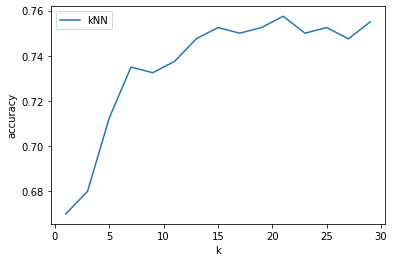

In [10]:
#Used the kNN implemtation from week05  
def distance_L2(a, b):
    "L2-distance using comprehension"
    s = sum((x - y) ** 2 for (x,y) in zip(a,b))
    return s ** 0.5

def majority(a):
    counts = Counter(a)
    return counts.most_common()[0][0]

class PyClassifier(): # May not need
    """Common methods to all python classifiers --- if any"""
    
    def accuracy(self,X_test, y_test, **kwargs):
        """Calculate the accuracy of the classifier 
        using the predict method"""
        predicted = [self.predict(a, **kwargs) for a in X_test]
        equal = len([(p, g) for (p,g) in zip(predicted, y_test) if p==g])
        return equal / len(y_test)

class PykNNClassifier(PyClassifier):
    """kNN classifier using pure python representations"""
    
    def __init__(self, k=3, dist=distance_L2):
        self.k = k
        self.dist = dist
        
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    
    def predict(self, a):
        X = self.X_train
        y = self.y_train
        distances = [(self.dist(a, b), b, c) for (b, c) in zip(X, y)]
        distances.sort()
        predictors = [c for (_,_,c) in distances[0: self.k]]
        return majority(predictors)
    
x = range(1, 30, 2)
accuracies = []
for k in x:
    kNN_cl = PykNNClassifier(k=k)
    kNN_cl.fit(X_train, t2_train)
    accuracies.append(kNN_cl.accuracy(X_val, t2_val))
plt.plot(x, accuracies, label="kNN")
plt.xlabel("k")
plt.ylabel("accuracy")
plt.legend()

In [11]:
for i in range(len(accuracies)):
    print(f"k={i*2}, {accuracies[i]}")

k=0, 0.67
k=2, 0.68
k=4, 0.7125
k=6, 0.735
k=8, 0.7325
k=10, 0.7375
k=12, 0.7475
k=14, 0.7525
k=16, 0.75
k=18, 0.7525
k=20, 0.7575
k=22, 0.75
k=24, 0.7525
k=26, 0.7475
k=28, 0.755


Wee see that the accuracy does not realy improve after k=16. So we use this as not to overfit.

In [12]:
kNN_cl = PykNNClassifier(k=16)
kNN_cl.fit(X_train, t2_train)
accuracy_kNN_cl = kNN_cl.accuracy(X_val, t2_val)
print(f"accuracy: {accuracy_kNN_cl}")

accuracy: 0.755


### Simple perceptron
Finally, run the simple perceptron (week06) on the same set, and report and store accuracy.

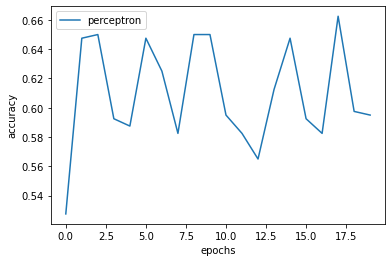

In [13]:
#Used the perceptron implemtation from week06
class PyPerClassifier(PyClassifier):
    """Simple perceptron python classifier"""
    
    def fit(self, X_train, y_train, eta=1, epochs=1):
        """Train the self.weights on the training data with learning
        rate eta, running epochs many epochs"""
        X_train = [[1]+list(x) for x in X_train] # Put bias in position 0      
        self.dim = dim = len(X_train[0])
        self.weights = weights = [0 for _ in range(dim)]
        # Initialize all weights to 0. There are better ways!

        for e in range(epochs):
            for x, t in zip(X_train, y_train):
                y = int(self.forward(x)>0)
                for i in range(dim):
                    weights[i] -= eta * (y - t) * x[i]
        
    def forward(self, x):
        """Calculate the score for the item x"""
        score = sum([self.weights[i]*x[i] for i in range(self.dim)])
        return score       
    
    def predict(self, x):
        """Predict the value for the item x"""
        x = [1] + list(x)
        score = self.forward(x)
        return int(score > 0)

x = range(0, 20)
accuracies = []
for e in x:
    per_cl = PyPerClassifier()
    per_cl.fit(X_train, t2_train, eta=0.1, epochs = e)
    accuracies.append(per_cl.accuracy(X_val, t2_val))
plt.plot(x, accuracies, label="perceptron")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

We se that after only one epoch the accuracy begins to oscillate. So i chose where the first peak is as number of epochs (epocs=2). eta also had no effect on the oscillation.

In [14]:
per_cl = PyPerClassifier()
per_cl.fit(X_train, t2_train, eta=0.1, epochs = 2)
accuracy_per_cl = per_cl.accuracy(X_val, t2_val)
print(f"accuracy: {accuracy_per_cl}")

accuracy: 0.65


### Summary
Report the accuracies for the four classifiers in a table.

Write a couple of sentences where you comment on what you see. Are the results as you expected?

In [15]:
accuracies = [accuracy_lin_cl, accuracy_log_cl, accuracy_kNN_cl, accuracy_per_cl]
list1 = ["linear", "logistic", "kNN", "perceptron"]
list2 = ["accuracy"]
pd.DataFrame(accuracies, list1, list2)

accuracy
linear        0.6025
logistic      0.6400
kNN           0.7550
perceptron    0.6500

The linear, logitic and percepron are quite similar in acuracy, where linear is ruffly 5% worse than the others. They are also all worse than kNN which makes sence sinse they are all linear clasifiers. Where as kNN kan make more complex dessision boundrries.

## Multi-class classifiers
We turn to the task of classifying when there are more than two classes, and the task is to ascribe one class to each input. We will now use the set (X, t).

### *k*NN
One of the classifiers can handle multiple classes without modifications: the *k*-nearest neighbors classifier. Train it on (X_train, t_train), test it on (X_val, t_val) for various values of *k*. Choose the one you find best and report the accuracy.

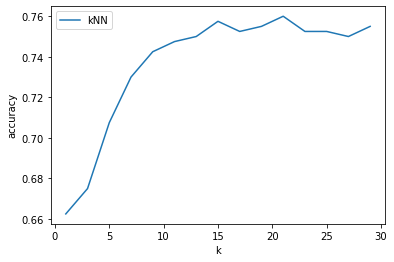

In [16]:
x = range(1, 30, 2)
accuracies = []
for k in x:
    kNN_cl = PykNNClassifier(k=k)
    kNN_cl.fit(X_train, t_train)
    accuracies.append(kNN_cl.accuracy(X_val, t_val))
plt.plot(x, accuracies, label="kNN")
plt.xlabel("k")
plt.ylabel("accuracy")
plt.legend()

The graph is quite simelar to the kNN on t2. I will chose k=16 here as well.

In [17]:
kNN_cl = PykNNClassifier(k=16)
kNN_cl.fit(X_train, t_train)
accuracy2_kNN_cl = kNN_cl.accuracy(X_val, t_val)
print(f"accuracy: {accuracy2_kNN_cl}")

accuracy: 0.76


### Logistic regression "one-vs-rest"
We saw in the lecture how a logistic regression classifier can be turned into a multi-class classifier using the one-vs-rest approach. We train one classifier for each class and assign the class which ascribes the highest probability.

Extend the logisitc regression classifier to a multi-class classifier. To do this, you must modify the target values from scalars to arrays. Train the resulting classifier on (X_train, t_train), test it on (X_val, t_val), and report the accuracy.

In [40]:
def logistic(x):
    return 1/(1+np.exp(-x))

class NumpyMultiClassLogReg(NumpyClassifier):

    def fit(self, X_train, t_train, eta = 0.1, diff=0.001):
        """X_train is a Nxm matrix, N data points, m features
        t_train are the targets values for training data"""
        
        (k, m) = X_train.shape
        X_train = add_bias(X_train)
        
        # weights for 3 classifiers
        weights_0 = np.zeros(m+1)
        weights_1 = np.zeros(m+1)
        weights_2 = np.zeros(m+1)
        self.weights_list = weights_list = [weights_0, weights_1, weights_2]
        
        # ALl sets where two classes are combined
        t_train_0 = (t_train == 0).astype('int')
        t_train_1 = (t_train == 1).astype('int')
        t_train_2 = (t_train == 2).astype('int')
        t_train_list = [t_train_0, t_train_1, t_train_2]
        
        # Train the three classifiers
        for i in range(3):
            trigger = True
            while trigger:
                old_weights = weights_list[i].copy()
                weights_list[i] -= eta / k *  X_train.T @ (self.forward(X_train, weights_list[i]) - t_train_list[i])

                counter = 0
                # checl if all wheghts changed less than diff
                for j in range(len(weights_list[i])):
                    if (abs(old_weights[j] - weights_list[i][j]) < diff):                  
                        counter += 1
                if counter == len(weights_list[i]):
                    trigger = False
        
    def forward(self, X, weights):
        return logistic(X @ weights)
    
    def predict(self, x, threshold=0.5):
        z = add_bias(x)
        score0 = self.forward(z, self.weights_list[0])
        score1 = self.forward(z, self.weights_list[1])
        score2 = self.forward(z, self.weights_list[2])
        
        predictions = np.zeros(len(score0))
        # prediction is class with highest probability
        for i in range(len(predictions)):
            maximum = np.max([score0[i], score1[i], score2[i]])
            
            if maximum == score0[i]:
                predictions[i] = 0
            elif maximum == score1[i]:
                predictions[i] = 1
            else: #  maximum == score2[i]
                predictions[i] = 2
                
        return predictions


log_cl = NumpyMultiClassLogReg()
log_cl.fit(X_train, t_train, diff=0.001)
accuracy2_log_cl = log_cl.accuracy(X_val, t2_val)
print(f"accuracy: {accuracy2_log_cl}")

accuracy: 0.6275


Discuss the results in a couple of sentences, addressing questions like

- How do the two classfiers compare?
- How do the results on the three-class classification task compare to the results on the binary task?
- What do you think are the reasons for the differences?

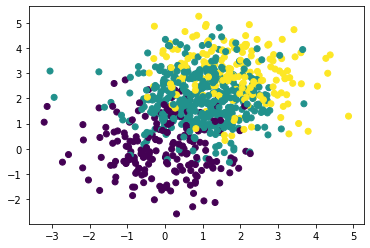

In [41]:
# plotting the data again
plt.scatter(X_train[:, 0], X_train[:, 1], c=t_train)

kNN was 15% more accurate than multiclass logitic. Compared to the same methods on the binary task the accuracies are almost the same. This can be because the purple and yelow (as seen above) classes are lineary seperable and easier to seperate. But the boundry between each of them and the geen class is harder to find. Which is makes the hard part of the muticlass clasification to seperate the green class, which is exatly the task for the binary classification.

## Adding non-linear features

We are returning to the binary classifier and the set (X, t2). As we see, some of the classifiers are not doing too well on the (X, t2) set. It is easy to see from the plot that this data set is not well suited for linear classifiers. There are several possible options for trying to learn on such a set. One is to construct new features from the original features to get better discriminants. This works e.g., for the XOR-problem. The current classifiers use two features: $x_1$ and $x_2$ (and a bias term $x_0$). Try to add three additional features of the form ${x_1}^2$, ${x_2}^2$, $x_1*x_2$ to the original features and see what the accuracies are now. Compare to the results for the original features in a 4x2 table.

Explain in a couple of sentences what effect the non-linear features have on the various classifiers. (By the way, some of the classifiers could probably achieve better results if we scaled the data, but we postpone scaling to part 2 of the assignment.)

In [167]:
def add_features(x):
        extra_features = np.zeros((len(x), 3))
        for i in range(len(x)):
            extra_features[i][0] = x[i][0] ** 2
            extra_features[i][1] = x[i][1] ** 2
            extra_features[i][2] = x[i][0] * x[i][0]
            
        return np.concatenate([x, extra_features], axis  = 1)

# Addding features
X_train_extra = add_features(X_train)
X_val_extra = add_features(X_val)

In [164]:
# Linear
extra_features_lin_cl = NumpyLinRegClass()
extra_features_lin_cl.fit(X_train_extra, t2_train, diff=0.001)
extra_features_accuracy_lin_cl = extra_features_lin_cl.accuracy(X_val_extra, t2_val)

C:\Users\espen\anaconda3\envs\in3050\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in matmul
C:\Users\espen\anaconda3\envs\in3050\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in matmul


KeyboardInterrupt: 

In [168]:
# Logitic
extra_features_log_cl = NumpyLogReg()
extra_features_log_cl.fit(X_train_extra, t2_train, diff=0.001)
extra_features_accuracy_log_cl = extra_features_log_cl.accuracy(X_val_extra, t2_val)

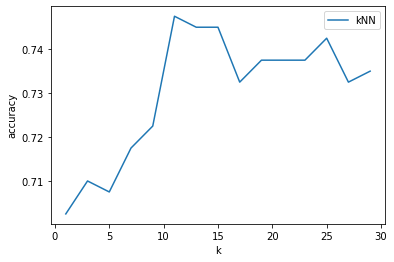

In [169]:
# kNN
x = range(1, 30, 2)
accuracies_kNN = []
for k in x:
    extra_features_kNN_cl = PykNNClassifier(k=k)
    extra_features_kNN_cl.fit(X_train_extra, t2_train)
    accuracies_kNN.append(extra_features_kNN_cl.accuracy(X_val_extra, t2_val))
plt.plot(x, accuracies_kNN, label="kNN")
plt.xlabel("k")
plt.ylabel("accuracy")
plt.legend()

In [170]:
extra_features_kNN_cl = PykNNClassifier(k=12)
extra_features_kNN_cl.fit(X_train_extra, t2_train)
extra_features_accuracy_kNN_cl = extra_features_kNN_cl.accuracy(X_val_extra, t2_val)

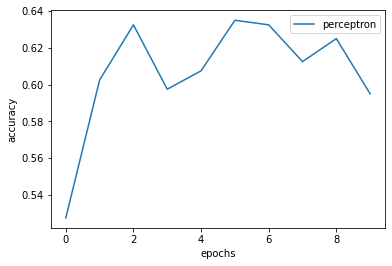

In [171]:
# perceptron
x = range(0, 10)
accuracies_per = []
for e in x:
    extra_features_per_cl = PyPerClassifier()
    extra_features_per_cl.fit(X_train_extra, t2_train, eta=0.1, epochs = e)
    accuracies_per.append(extra_features_per_cl.accuracy(X_val_extra, t2_val))
plt.plot(x, accuracies_per, label="perceptron")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

In [172]:
extra_features_per_cl = PyPerClassifier()
extra_features_per_cl.fit(X_train_extra, t2_train, eta=0.1, epochs = 5)
extra_features_accuracy_per_cl = extra_features_per_cl.accuracy(X_val_extra, t2_val)

In [173]:
extra_features_accuracy_lin_cl = None
accuracies = [[accuracy_lin_cl, extra_features_accuracy_lin_cl], [accuracy_log_cl, extra_features_accuracy_log_cl], [accuracy_kNN_cl, extra_features_accuracy_kNN_cl], [accuracy_per_cl, extra_features_accuracy_per_cl]]
list1 = ["linear", "logistic", "kNN", "perceptron"]
list2 = ["original", "extended"]
pd.DataFrame(accuracies, list1, list2)

original  extended
linear        0.6025       NaN
logistic      0.6400     0.690
kNN           0.7550     0.750
perceptron    0.6500     0.635

Encountered problems with overflow on the wheights for the linear method.    
The logitic did a little better with an 5% increase.    
kNN did about the same.    
While the perceptron actualy did worse.

# Part II
## Multi-layer neural networks
We will implement the Multi-layer feed forward network (MLP, Marsland sec. 4.2.1). We will do so in two steps. In the first step, we will work concretely with the dataset (X, t). We will initialize the network and run a first round of training, i.e. one pass throught the algorithm at p. 78 in Marsland.

In the second step, we will turn this code into a more general classifier. We can train and test this on (X, t), but also on other datasets.

First of all, you should scale the X.

In [209]:
class Scalar():
    
    def __init__(self, x):
        """Creates the scalar for the min-max scalar"""
        self.max_val = np.zeros(len(x[0])) # lagest value in column
        self.min_val = np.zeros(len(x[0])) # smalest value in column
    
        transpose = x.T
        for i in range(len(self.max_val)):
            self.max_val[i] = np.max(transpose[i])
            self.min_val[i] = np.min(transpose[i])
            
    def scale(self, x):
        """Max-min scaling"""
        x_scaled = np.zeros(x.shape)
        for i in range(len(x)):
            for j in range(len(x[0])):
                x_scaled[i][j] = (x[i][j] - self.min_val[j]) / (self.max_val[j] - self.min_val[j])

        return x_scaled

In [210]:
S = Scalar(X_train)
X_train_scaled = S.scale(X_train)
X_val_scaled = S.scale(X_val)
X_test_scaled = S.scale(X_test)

In [390]:
# prepare t for the network
def int_to_array(t):
    output = np.zeros((len(t), 3))
    for i in range(len(t)):
        if t[i] == 0:
            output[i] = np.array([1,0,0])
        elif t[i] == 1:
            output[i] = np.array([0,1,0])
        else:
            output[i] = np.array([0,0,1])
            
    return output

tt_train = int_to_array(t_train)
tt_val = int_to_array(t_val) 
tt_test = int_to_array(t_test)

## Step1: One round of training

### Initialization
We will only use one hidden layer. The number of nodes in the hidden layer will be a hyper-parameter provided by the user; let's call it *dim_hidden*. (*dim_hidden* is called *M* by Marsland.) Initially, we will set it to 6. This is a hyper-parameter where other values may give better results, and the hyper-parameter could be tuned.

Another hyper-parameter set by the user is the learning rate. We set the initial value to 0.01, but also this may need tuning.

In [450]:
eta = 0.01 #Learning rate
dim_hidden = 6

We assume that the input *X_train* (after scaling) is a matrix of dimension *P x dim_in*, where *P* is the number of training instances, and *dim_in* is the number of features in the training instances (*L* in Marsland). Hence we can read *dim_in* off from *X_train*. Similarly, we can read *dim_out* off from *t_train*. Beware that *t_train* must be given the form of *P x dim_out* at some point, cf. the "one-vs-all" exercise above.

In [451]:
dim_in = (np.asmatrix(X_train_scaled)).shape[1]
dim_out = (np.asmatrix(tt_train)).shape[1]

print(dim_in, dim_out)

2 3


We need two sets of weights: weights1 between the input and the hidden layer, and weights2, between the hidden layer and the output. Make the weight matrices and initialize them to small random numbers. Make sure that you take the bias terms into consideration and get the correct dimensions.

In [452]:
weights1 = np.random.uniform(low=-1, high=1, size=(dim_in+1, dim_hidden)) # +1 is for the bias
weights2 = np.random.uniform(low=-1, high=1, size=(dim_hidden+1, dim_out)) # +1 is for the bias
print(weights1)
print(weights2)

[[ 0.78987316  0.19009433  0.82105092  0.04542709 -0.55450982  0.31174087]
 [-0.56919038  0.1234926  -0.76782273 -0.11669422 -0.96432547  0.28560157]
 [-0.10022911  0.83904517 -0.42730282  0.88778372 -0.66973277  0.08868376]]
[[-0.30492989 -0.70091264 -0.03680137]
 [-0.51303501  0.48044228 -0.09992123]
 [-0.66461565  0.33381764  0.59030112]
 [-0.30137736 -0.1700153   0.35265113]
 [-0.63972131  0.95188427  0.98454222]
 [ 0.58533926 -0.51593763 -0.14225075]
 [ 0.15896901 -0.97683265 -0.3279489 ]]


### Forwards phase
We will run the first step in the training, and start with the forward phase. Calculate the activations after the hidden layer and after the output layer. We will follow Marsland and use the logistic (sigmoid) activation function in both layers. Inspect whether the results seem reasonable with respect to format and values.

In [453]:
X = add_bias(X_train_scaled)
hidden_activations = logistic(X @ weights1)
print(hidden_activations.shape)
print(hidden_activations[0:5])

(800, 6)
[[0.59807676 0.65602334 0.53974573 0.59305741 0.19063326 0.62855927]
 [0.58350673 0.6879243  0.50773257 0.62496323 0.16402321 0.63702428]
 [0.63359357 0.63864054 0.59327324 0.58879757 0.23780123 0.61031244]
 [0.62617455 0.67220431 0.57050346 0.62482166 0.21325353 0.61568077]
 [0.58665214 0.73044272 0.49340727 0.67828027 0.14999582 0.63779343]]


In [454]:
h = add_bias(hidden_activations)
output_activations = logistic(h @ weights2)
print(output_activations.shape)
print(output_activations[0:5])

(800, 3)
[[0.20127901 0.39313001 0.69670757]
 [0.1951261  0.40389748 0.70538778]
 [0.20202491 0.39112635 0.69673862]
 [0.19436615 0.40387203 0.70714086]
 [0.18470487 0.42216945 0.72052279]]


### Backwards phase
Calculate the delta terms at the output. We assume, like Marsland, that we use sums of squared errors. (This amounts to the same as using the mean square error).

In [455]:
delta_output = np.zeros((len(output_activations), dim_out))

for i in range(len(output_activations)):
    delta_output = (output_activations[i] - tt_train) * output_activations * (1 - output_activations)
print(delta_output)

[[ 0.0323813  -0.14493879  0.14725132]
 [ 0.03163326 -0.1462665   0.14481908]
 [-0.1287399   0.09347035  0.1472428 ]
 ...
 [-0.13320261  0.09210594  0.15060101]
 [ 0.03190697 -0.14579649  0.14573026]
 [ 0.03239816  0.09358624 -0.06403633]]


Calculate the delta terms in the hidden layer.

In [456]:
delta_hidden = np.zeros((len(hidden_activations), dim_hidden))
sums = (delta_output @ weights2.T).sum(axis=1) # sum of delta at output weighted by the connections between them

for i in range(len(hidden_activations)):
    delta_hidden[i] = hidden_activations[i] * (1 - hidden_activations[i]) * s[i]

print(delta_hidden)

[[-0.00245346 -0.00230317 -0.00253551 -0.00246325 -0.00157479 -0.00238295]
 [-0.00250762 -0.00221518 -0.00257896 -0.00241844 -0.00141484 -0.00238584]
 [-0.01955904 -0.01944329 -0.02032971 -0.02039837 -0.0152706  -0.02003745]
 ...
 [-0.01947858 -0.02034314 -0.01999491 -0.02098865 -0.01658381 -0.02024936]
 [-0.00249166 -0.00224984 -0.00256753 -0.00243905 -0.00146635 -0.00238488]
 [ 0.0373418   0.03589079  0.03874998  0.03805787  0.02614086  0.03708406]]


Update the weights.
Check that they have changed.
As the weights depend on the random initialization, there is no unique correct solution at this point. But you should be able to see that the weights have been updated.

In [457]:
print(weights2)
print(weights1)

[[-0.30492989 -0.70091264 -0.03680137]
 [-0.51303501  0.48044228 -0.09992123]
 [-0.66461565  0.33381764  0.59030112]
 [-0.30137736 -0.1700153   0.35265113]
 [-0.63972131  0.95188427  0.98454222]
 [ 0.58533926 -0.51593763 -0.14225075]
 [ 0.15896901 -0.97683265 -0.3279489 ]]
[[ 0.78987316  0.19009433  0.82105092  0.04542709 -0.55450982  0.31174087]
 [-0.56919038  0.1234926  -0.76782273 -0.11669422 -0.96432547  0.28560157]
 [-0.10022911  0.83904517 -0.42730282  0.88778372 -0.66973277  0.08868376]]


In [458]:
eta = 0.1

for i in range(len(weights2)):
    weights2[i] -= eta * (delta_output[i] * output_activations[i])

for i in range(len(weights1)):
    weights1[i] -= eta * (delta_hidden[i] * hidden_activations[i])

In [459]:
print(weights2)
print(weights1)

[[-0.30558165 -0.69521466 -0.04706048]
 [-0.51365225  0.48634995 -0.11013659]
 [-0.66201478  0.33016177  0.58004215]
 [-0.30199038 -0.16410813  0.34244602]
 [-0.64028155  0.94784221  0.98894049]
 [ 0.58823675 -0.51933656 -0.15256366]
 [ 0.16153672 -0.98052496 -0.33820228]]
[[ 0.7900199   0.19024542  0.82118778  0.04557318 -0.5544798   0.31189065]
 [-0.56904406  0.12364498 -0.76769179 -0.11654308 -0.96430226  0.28575355]
 [-0.09898986  0.8402869  -0.42609671  0.88898477 -0.66936963  0.08990668]]


##  Step 2: A Multi-layer neural network classifier

You want to train and test a classifier on (X, t). You could have put some parts of the code in the last step into a loop and run it through some iterations. But instead of copying code for every network we want to train, we will build a general Multi-layer neural network classfier as a class. This class will have some of the same structure as the classifiers we made for linear and logistic regression. The task consists mainly in copying in parts from what you did in step 1 into the template below. Remember to add the *self*- prefix where needed, and be careful in your use of variable names.

In [471]:
#From the linear regression implemtation from week07
def add_bias(X):
    # Put bias in position 0
    sh = X.shape
    if len(sh) == 1:
        #X is a vector
        return np.concatenate([np.array([1]), X])
    else:
        # X is a matrix
        m = sh[0]
        bias = np.ones((m,1)) # Makes a m*1 matrix of 1-s
        return np.concatenate([bias, X], axis  = 1)
    
def logistic(x):
    return 1/(1+np.exp(-x))    
    
class MNNClassifier():
    """A multi-layer neural network with one hidden layer"""
    
    def __init__(self, eta = 0.001, dim_hidden = 6):
        """Initialize the hyperparameters"""
        self.eta = eta
        self.dim_hidden = dim_hidden
        
    def fit(self, X_train, t_train, epochs = 100):
        """Initialize the weights. Train *epochs* many epochs."""
        
        dim_in = (np.asmatrix(X_train)).shape[1]
        dim_out = (np.asmatrix(t_train)).shape[1]
        
        self.weights1 = weights1 = np.random.uniform(low=-1, high=1, size=(dim_in+1, dim_hidden)) # +1 is for the bias
        self.weights2 = weights2 = np.random.uniform(low=-1, high=1, size=(dim_hidden+1, dim_out)) # +1 is for the bias

        for e in range(epochs):
            # Run one epoch of forward-backward
            # Forwards
            hidden_activations, output_activations = self.forward(X_train)
            
            # deltas
            delta_output = np.zeros((len(output_activations), dim_out))
            for i in range(len(output_activations)):
                delta_output = (output_activations[i] - tt_train) * output_activations * (1 - output_activations)
            
            delta_hidden = np.zeros((len(hidden_activations), dim_hidden))
            sums = (delta_output @ weights2.T).sum(axis=1) # sum of delta at output weighted by the connections between them
            for i in range(len(hidden_activations)):
                delta_hidden[i] = hidden_activations[i] * (1 - hidden_activations[i]) * s[i]
            
            # backward
            for i in range(len(weights2)):
                weights2[i] -= eta * (delta_output[i] * output_activations[i])

            for i in range(len(weights1)):
                weights1[i] -= eta * (delta_hidden[i] * hidden_activations[i])
            
    def forward(self, X):
        """Perform one forward step. 
        Return a pair consisting of the outputs of the hidden_layer
        and the outputs on the final layer"""
        x = add_bias(X)
        hidden_activations = logistic(x @ self.weights1)
        
        h = add_bias(hidden_activations)
        output_activations = logistic(h @ self.weights2)
        
        return hidden_activations, output_activations

    # From the NumpyClassifier
    def accuracy(self, X_test, y_test):
        """Calculate the accuracy of the classifier for the pair (X_test, t_test)
        Return the accuracy"""
        pred = self.predict(X_test)
        if len(pred.shape) > 1:
            pred = pred[:,0]
        return sum(pred==y_test)/len(pred)
    
    def predict(self, X):
        hidden_activations, output_activations = self.forward(X)
        
        predictions = np.zeros(len(output_activations))
        # prediction is class with highest probability/number
        for i in range(len(predictions)):
            maximum = np.max(output_activations[i])

            if maximum == output_activations[i][0]:
                predictions[i] = 0    
            elif maximum == output_activations[i][1]:
                predictions[i] = 1            
            elif maximum == output_activations[i][2]:
                predictions[i] = 2

        return predictions

Train the network on (X_train, t_train) (after scaling), and test on (X_val, t_val). Adjust hyperparameters or number of epochs if you are not content with the result.

In [494]:
MNN_cl = MNNClassifier(eta = 0.001)
MNN_cl.fit(X_train_scaled, tt_train, epochs = 100)
acc = MNN_cl.accuracy(X_val_scaled, t_val)
print(acc)

0.4725


## Make a neural network classifier for (X, t2)
Let us see whether a multilayer neural network can learn a non-linear classifier.
Train it on (X_train, t2_train) and test it on (X_val, t2_val).
Tune the hyper-parameters for the best result.

In [499]:
MNN_cl = MNNClassifier(eta = 0.001)
tt2_train = int_to_array(t2_train)
MNN_cl.fit(X_train, tt2_train, epochs = 100)
acc = MNN_cl.accuracy(X_val, t2_val)
print(acc)

0.4675


## For master's students: Early stopping
There is a danger of overfitting if we run too many epochs of training. One way to control that is to use early stopping. We can use (X_val, t_val) as valuation set when training on (X_train, t_train).

Let *e=50* or *e=10* (You may try both or choose some other number) After *e* number of epochs, calculate the loss for both the training set (X_train, t_train) and the validation set (X_val, t_val), and plot them as in figure 4.11 in Marsland. 

Modify the code so that the training stops if the loss on the validation set is not reduced by more than *t* after *e* many epochs, where *t* is a threshold you provide as a parameter. 

# Part III: Final testing
Take the best classifiers that you found for the training sets (X, t) and (X, t2) and test them on (X_test, t_test) and (X_test, t2_test), respectively. Compute accuracy, the confusion matrix, precision and recall. Answer in 2-3 sentences: How do the accuracies compare to the results on the validation sets?

KNN was the best method for both sets.

In [500]:
kNN_cl_t2 = PykNNClassifier(k=16)
kNN_cl_t2.fit(X_train, t2_train)
accuracy_t2_kNN_cl = kNN_cl.accuracy(X_test, t2_test) # accyracy 0.755 for the validation set

kNN_cl_t = PykNNClassifier(k=16)
kNN_cl_t.fit(X_train, t_train)
accuracy2_t_kNN_cl = kNN_cl.accuracy(X_test, t_test) # accyracy 0.76 for the validation set

print(f"accuracy on t2 set: {accuracy_t2_kNN_cl}")
print(f"accuracy on t set: {accuracy2_t_kNN_cl}")

accuracy on t2 set: 0.7575
accuracy on t set: 0.5775


We see that for the t2 set the accuracy was the same as for the validation set (0.755).        
While for the t set the accuracy is much worse, about 20% worse.    
This shows that the t2 classifier was (probably) trained and tuned better than the classifier for t.

In [507]:
predicted_t2 = [kNN_cl_t2.predict(a) for a in X_test]
predicted_t = [kNN_cl_t.predict(a) for a in X_test]

In [508]:
# From week05 solution
def cf_matrix(predicted, gold):
    table = np.zeros((2,2))
    for p,g in zip(predicted, gold):
        table[int(p), g] +=1
    print(28*" "+"gold")
    print("{:20}|{:>9}|{:>9}|".format(" ","neg", "pos"))
    print(10*" "+30*"-")
    print("{:10}{:10}|{:9}|{:9}|".format(" ","neg",table[0,0], table[0,1]))
    print("predicted "+30*"-")
    print("{:10}{:10}|{:9}|{:9}|".format(" ","pos",table[1,0], table[1,1]))
    print(10*" "+30*"-")

In [509]:
cf_matrix(predicted_t2, t2_test)

                            gold
                    |      neg|      pos|
          ------------------------------
          neg       |    140.0|     36.0|
predicted ------------------------------
          pos       |     65.0|    159.0|
          ------------------------------


Pressision: 159 / (159+65) = 0.61
Recall: 159 / (159 + 36) = 0.82

In [530]:
def cf_matrix_3x3(predicted, gold):
    # _predicted_gold
    _0_0 = 0; _0_1 = 0; _0_2 = 0 
    _1_0 = 0; _1_1 = 0; _1_2 = 0 
    _2_0 = 0; _2_1 = 0; _2_2 = 0  
    
    for p, g in zip(predicted_t, t_test):
        if p == 0:
            if g == 0:
                _0_0 += 1  
            elif g == 1:
                _0_1 += 1
            elif g == 2:
                _0_2 += 1
        elif p == 1:
            if g == 0:
                _1_0 += 1
            elif g == 1:
                _1_1 += 1
            elif g == 2:
                _1_2 += 1
        elif p == 2:
            if g == 0:
                _2_0 += 1
            elif g == 1:
                _2_1 += 1
            elif g == 2:
                _2_2 += 1
    
    accuracies = [[_0_0, _0_1, _0_2], [_1_0, _1_1, _1_2], [_2_0, _2_1, _2_2]]
    p_list = ["predicted 0", "predicted 1", "predicted 2"]
    g_list = ["gold 0", "gold 1", "gold 2"]
    return pd.DataFrame(accuracies, p_list, g_list)
            
cf_matrix_3x3(predicted_t, t_test)

gold 0  gold 1  gold 2
predicted 0      69       9       0
predicted 1      23     160      43
predicted 2       0      26      70